In [1]:
%config InlineBackend.figure_format = 'svg' # change output plot display format to 'svg'

# import the required modules for this notebook
import numpy
import matplotlib.pyplot as plt

# import the helper functions from the parent directory,
# these help with things like graph plotting and notebook layout
import sys
sys.path.append('..')
from helper_functions import *

# set things like fonts etc - comes from helper_functions
set_notebook_preferences()

# add a show/hide code button - also from helper_functions
toggle_code(title = "setup code")

## Multi-class softmax classification

We will now extend the [binary logistic regression model](classification_logistic_regression_ML_fitting.ipynb) to handle multiple classes. 

###  The Softmax Classification Model

As before, each datapoint comprises an input $\mathbf{x}_n$ and an output value $y_n$. Now the output $y_n = k$ indicates which of $K$ classes the $n^{th}$ datapoint belongs to. Binary classification is recovered when $K=2$.

The softmax model also comprises two stages. The first stage computes $k$ activations $a_{n,k} = \mathbf{w}_k^\top \mathbf{x}_n$ using a weight vector for each class $\{\mathbf{w}_k\}_{k=1}^K$. The second stage passes this set of activations into a **softmax function** which returns the probability that the datapoint belongs to each of the K classes (i.e. a K dimensional vector of probabilities) which has elements 

$$
p(y_{n} = k |\mathbf{x}_n, \{\mathbf{w}_k\}_{k=1}^K) = \frac{\exp(a_{n,k})}{\sum_{k'=1}^K \text{exp}(a_{n,k'})} = \frac{\text{exp}(\mathbf{w}_k^\top \mathbf{x}_n)}{\sum_{k'=1}^K \exp(\mathbf{w}_{k'}^\top \mathbf{x}_n)},
$$

Notice that by construction the softmax function is normalised 

$$\sum_{k=1}^K p(y_{n} = k |\mathbf{x}_n, \{\mathbf{w}_k\}_{k=1}^K) = \frac{\sum_{k=1}^K \exp(a_{n,k})}{\sum_{k'=1}^K \text{exp}(a_{n,k'})} = 1$$

In this way, the softmax parameterises a [categorical distribution](https://en.wikipedia.org/wiki/Categorical_distribution) over the output variable, whereas the logistic function parameterised a [Bernoulli distribution](https://en.wikipedia.org/wiki/Bernoulli_distribution).

Let's plot some examples of this model for K=3 classes and D=2 dimensional inputs. Each column of the plot below corresponds to a different softmax model each with its own weights $W^{(m)} = [\mathbf{w}_1^{(m)},\mathbf{w}_2^{(m)},\mathbf{w}^{(m)}_3]$. Each row shows how the probability of one of the three classes varies across the input space. The probability contours are not linear, however it turns out that the decision boundaries are. For more insight into the softmax function, see [question 1](#Questions) below.

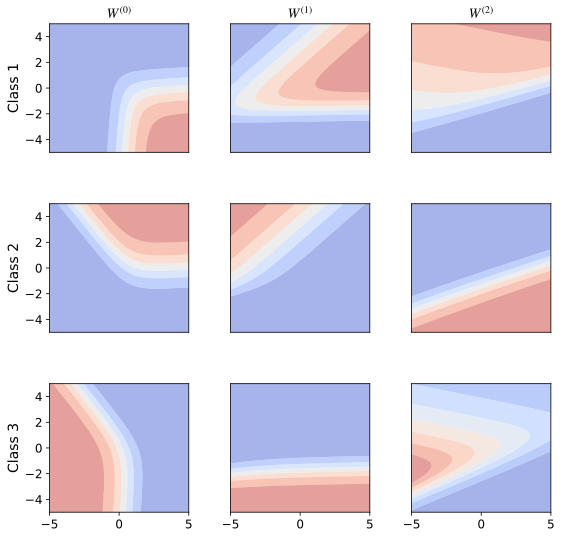

In [2]:
def softmax(x):
    return (np.exp(x).T/np.sum(np.exp(x), axis = 1)).T # define softmax function

fig = plt.figure(figsize=(9, 9))

no_increments = 100

x1 = np.linspace(-5,5,no_increments)
x2 = np.linspace(-5,5,no_increments)

for w in range(0,3):
    
    W = np.random.randn(3,3)
    
    grid = np.stack(np.meshgrid(x1,x2), axis = -1)

    grid = grid.reshape((-1, 2))

    grid = np.append(np.ones(shape = (grid.shape[0], 1)), grid, axis = 1)
    
    probs = softmax(grid.dot(W)).reshape((no_increments, no_increments, 3))
    
    for class_ in range(1,4):
        
        # adding a subplot in appropriate location
        ax = fig.add_subplot(3, 3, (class_-1) * 3 + (w+1))
        
        ax.contourf(x1,x2,probs[:,:,class_-1],cmap=matplotlib.cm.coolwarm,alpha=0.5)
        
        if w == 0:
            
            beautify_plot({"y":"Class " + str(class_)})
            
        else:
            
            plt.yticks([])
            
        if class_ == 1:
            
            beautify_plot({"title":r"$W^{(" + str(w) + ")}$"})
            
        if class_ != 3:
        
            plt.xticks([])

plt.subplots_adjust(hspace = 0.4,wspace = 0.3)
plt.show()
        
toggle_code()

### Fitting using maximum-likelihood estimation

Having gained some intuition about the model, we now consider maximum likelihood fitting. 

The likelihood can be written in a compact form using a one-hot encoding of the class labels. That is, we can encode the output $y_n=k$ into a vector of length $K$ comprising $K-1$ zeros and a one in the $k^{\text{th}}$ element e.g. for $K=4$ classes if the $n^{\text{th}}$ datapoint belongs to the third class $y_n=3$ we have $\mathbf{y}_n = [0,0,1,0]$. These one-hot encodings can be stacked into an N-by-K matrix with elements $y_{n,k}$ and will help us do the book keeping associated with computing the correct output probability for each datapoint. Armed with this new representation of the output, we can write the probability of the output given the weights and the inputs as,

\begin{align}
p(\{y_{n}\}_{n=1}^N|\{\mathbf{x}_n\}_{n=1}^N, \{\mathbf{w}_k\}_{k=1}^K) &= \prod_{n = 1}^N \prod_{k = 1}^K s_{n,k}^{y_{n,k}}.
\end{align}

Here we have denoted the output of the softmax function for each datapoint as $s_{n,k} = p(y_{n} = k |\mathbf{x}_n, \{\mathbf{w}_k\}_{k=1}^K) = \text{exp}(\mathbf{w}_k^\top \mathbf{x}_n)\big/\sum_{k'} \exp(\mathbf{w}_{k'}^\top \mathbf{x}_n)$. 

In case it is not clear, let's briefly consider the the trick of raising the softmax output to the power $y_{n,k}$ through a simple example. Let $N=1$ and $y_1 = 3$ so that $\mathbf{y}_1 = [y_{1,1},y_{1,2},y_{1,3},y_{1,4}] = [0,0,1,0]$. The right hand side of the likelihood is therefore

$$\prod_{k = 1}^K s_{n,k}^{y_{n,k}} = s_{n,1}^{0} s_{n,2}^{0} s_{n,3}^{1} s_{n,4}^{0} = s_{n,3}^{1} = p(y_{1} = 3 |\mathbf{x}_n, \{\mathbf{w}_k\}_{k=1}^K).$$

So everything works as it should do. The probability of the output given the weights and the inputs is also called the likelihood of the parameters. The log-likelihood is therefore

\begin{align}
\mathcal{L}(\{\mathbf{w}\}_{k=1}^K) &= \sum_{n = 1}^N \sum_{k = 1}^K y_{n,k} \log s_{n,k}
\end{align}

Now we can numerically optimise the log-likelihood using gradient ascent. This requires computation of the derivatives of $\mathcal{L}(\{\mathbf{w}\}_{k=1}^K)$ with respect to the weights, 

\begin{align}
\frac{\partial \mathcal{L}(\{\mathbf{w}\}_{k=1}^K)}{\partial \mathbf{w}_j} = \sum^N_{n = 1} (y_{n,j} - s_{n,j}) \mathbf{x}_n.
\end{align}

The full derivation of the gradient can be found below. Notice how it is composed of a sum over contributions from each datapoint, and each contribution involves the prediction error $y_{n,j} - s_{n,j}$ multiplied by the input $\mathbf{x}_n$. 

<details>
<summary>Derivation of the gradient of the softmax log-likelihood</summary>
<div>
    Starting from the expression

\begin{align}
\mathcal{L}(\{\mathbf{w}\}_{k=1}^K) &= \sum_{n = 1}^N \sum_{k = 1}^K y_{n,k} \text{log}~s_{n,k},
\end{align}

and taking the derivative w.r.t. $\mathbf{w}_j$ we see:


\begin{align}
\frac{\partial \mathcal{L}(\{\mathbf{w}\}_{k=1}^K)}{\partial \mathbf{w}_j} &= \sum_{n = 1}^N\sum_{k = 1}^K y_{n,k} \frac{1}{s_{n,k}} \frac{\partial s_{n,k}}{\partial \mathbf{w}_j} = \sum_{n = 1}^N\sum_{k = 1}^K y_{n,k} \frac{1}{s_{n,k}} \frac{\partial s_{n,k}}{\partial a_{n,j}} \frac{\partial a_{n,j}}{\mathbf{w}_j}\\
~\\
&= \sum_{n = 1}^N\sum_{k = 1}^K y_{n,k} (\delta_{k,j} - s_{n,j}) \mathbf{x}_n\\
~\\
\end{align}

where $\delta_{k,j}$ is a [Kronecker delta](https://en.wikipedia.org/wiki/Kronecker_delta) and we have used the identity

\begin{align}
\frac{\partial s_{n,k}}{ \partial a_{n,j}} = s_{n,k}(\delta_{k,j} - s_{n,j}).
\end{align}

Then considering that for each $n$, $y_{n,k}$ is $1$ for a single value of $k$ and $0$ for all other values of $k$:

\begin{align}
\frac{\partial \mathcal{L}(\{\mathbf{w}\}_{k=1}^K)}{\partial \mathbf{w}_j} &= \sum_{n = 1}^N\sum_{k = 1}^K y_{n,k}(\delta_{k,j} - s_{nj})\mathbf{x}_n\\
~\\
&= \sum_{n = 1}^N\sum_{k = 1}^K (y_{n,j} - s_{n,j})\mathbf{x}_n\\
\end{align}

arriving at the final result.
</div>
</details>

Now let's write down code for gradient ascent of the softmax classification likelihood, just as we did for logistic classication.

In [3]:
def softmax(x):
    return (np.exp(x).T/np.sum(np.exp(x), axis = 1)).T # define softmax function for convenience

def softmax_gradient_ascent(x, y, init_weights, no_steps, stepsize):
    
    x = np.append(np.ones(shape = (x.shape[0], 1)), x, axis = 1) # add 1's to the inputs as before
    
    w = init_weights.copy() # copy weights as before
    
    w_history, log_liks = [], [] # arrays for storing weights and log-liklihoods as before

    for n in range(no_steps): # in this part we optimise log-lik w.r.t. ws
        
        log_liks.append(np.sum(y*np.log(softmax(x.dot(w))))) # record current log-lik as before
        
        w_history.append(w.copy()) # record current weights as before
    
        soft_ = softmax(x.dot(w)) # using our neat convenience function
        
        dL_dw = (x.T).dot(y - soft_)/x.shape[0]
        
        w += stepsize*dL_dw # update weights and repeat
    
    return np.array(w_history), np.array(log_liks)

toggle_code(title = "gradient ascent algorithm", on_load_hide = False)

We can now run gradient ascent on the Iris dataset with all 3 classes included. Let's start by running it with just two of the input dimensions retained (sepal length and width) so that we can visualise the results easily. In the plot below, each point is coloured with the RGB value representing the probabilistic prediction the trained model makes for each class ($0$,$1$ and $2$ respectively) at this location. 

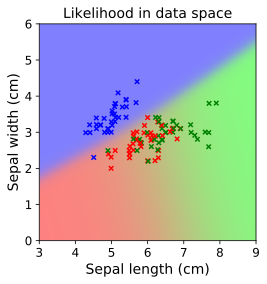

In [4]:
x = np.load('iris_inputs_full.npy')
y = np.load('iris_labels.npy')

y_ = np.zeros(shape = (y.shape[0], 3))
y_[np.arange(y.shape[0]), y] = 1

no_train = (x.shape[0] * 3) // 4
x_train, x_test, y_train, y_test = x[:no_train, :2], x[no_train:, :2], y_[:no_train], y_[no_train:]

init_weights = np.zeros(shape = (x_train.shape[1] + 1, 3))

w_history, log_liks = softmax_gradient_ascent(x_train, y_train, init_weights, 10 ** 4, 0.05)

min_x, max_x, min_y, max_y, res = 3, 9, 0, 6, 1000
grid = np.stack(np.meshgrid(np.linspace(min_x, max_x, res), np.linspace(min_y, max_y, res)), axis = -1)
grid = grid.reshape((-1, 2))
grid = np.append(np.ones(shape = (grid.shape[0], 1)), grid, axis = 1)

probs = softmax(grid.dot(w_history[-1])).reshape((res, res, 3))
rgb_colors = np.roll(probs, -1, axis  = -1)
plt.imshow(rgb_colors, extent = [min_x, max_x, min_y, max_y], alpha = 0.5, origin='lower')
plt.scatter(x_train[:, 0], x_train[:, 1], marker = 'x', s = 20, color = np.array(['b', 'r', 'g'])[y[:no_train]])
beautify_plot({"title":r"Likelihood in data space", "x":"Sepal length (cm)", "y":"Sepal width (cm)"})
plt.show()

toggle_code()

Now that we have visualised the probabilities, we can apply the gradient-ascent algorithm to the full Iris dataset, with all of the input dimesions retained. First lets see how the log-likelihood changes with iteration number:

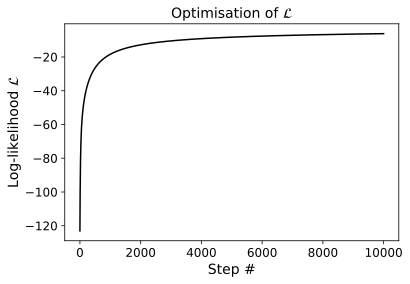

In [5]:
x = np.load('iris_inputs_full.npy')
y = np.load('iris_labels.npy')

y_ = np.zeros(shape = (y.shape[0], 3))
y_[np.arange(y.shape[0]), y] = 1

no_train = (x.shape[0] * 3) // 4
x_train, x_test, y_train, y_test = x[:no_train], x[no_train:], y_[:no_train], y_[no_train:]

init_weights = np.zeros(shape = (x_train.shape[1] + 1, 3))

w_history, log_liks = softmax_gradient_ascent(x_train, y_train, init_weights, 10 ** 4, 0.05)
beautify_plot({"title":r"Optimisation of $\mathcal{L}$", "x":"Step #", "y":"Log-likelihood $\mathcal{L}$"})
plt.plot(log_liks, color = 'black')
plt.show()

toggle_code()

Now lets test the accuracy of our model on the test data:

In [6]:
def softmax_test_accuracy(test_x, test_y, w):
    x_ = np.append(np.ones(shape = (test_x.shape[0], 1)), test_x, axis = 1)
    y_ = softmax(x_.dot(w))
    return (np.argmax(y_, axis = 1) == np.argmax(y_test, axis = 1)).mean()

print('Classification accuracy for full iris dataset = {0:.1f}%'.format(softmax_test_accuracy(x_test, y_test, w_history[-1])*100))

toggle_code()

Classification accuracy for full iris dataset = 94.7%


### Summary

The multi-class softmax classification model comprises two steps:  

1. Compute $K$ activations, one for each class, each of which are linear projections of the input $a_{n,k} = \mathbf{w}_k^\top \mathbf{x}_n$
2. Pass the $K$ activations into the softmax function to get a vector of $K$ elements which are the class membership probabilities $p(y_{n} = k |\mathbf{x}_n, \{\mathbf{w}_k\}_{k=1}^K) = \text{exp}(\mathbf{w}_k^\top \mathbf{x}_n)\big/\sum_{k'} \exp(\mathbf{w}_{k'}^\top \mathbf{x}_n)$

The log-likelihood and its derivatives can be compactly written using a one-hot encoding of the training data's outputs. Gradient ascent can then be used to numerically optimise the log-likelihood. 

In the [next section](classification_non-linear.ipynb) we will look at how to generalise this method to non-linear classification.

### Questions

1. **Why the name 'softmax' and relating softmax classification to logistic classification**

Consider the softmax classification function:

$$
p(y_{k} = k |\mathbf{x}, \{\mathbf{w}_k\}_{k=1}^K)  = \frac{\text{exp}(\mathbf{w}_k^\top \mathbf{x})}{\sum_{k'=1}^K \exp(\mathbf{w}_{k'}^\top \mathbf{x})},
$$



What happens to the softmax function as the magnitude of the weights tends to infinity $|\mathbf{w}_k| \rightarrow \infty$?

Consider K=2 classes, compare and contrast the softmax classification model to binary logistic classification. Is the softmax function **[identifiable](https://en.wikipedia.org/wiki/Identifiability)**?

<details>
<summary>Answer</summary>
<div>
   
   <div class="row">
  <div class="column">
    <img src="softmax-solution-1.png" alt="Snow" style="width:100%; float: center; padding: 0px">
    <img src="softmax-solution-2.png" alt="Snow" style="width:100%; float: center; padding: 0px">
  </div>
    </div>
    Notice that although the softmax and logistic functions are identical for $K=2$ classes, the parameterisation is different. The softmax version is over-parameterised having two sets of parameters whose difference affects the input-output function. For this reason the parameters of the softmax are not identifiable: adding the same vector to each weight $\mathbf{w}_k \leftarrow \mathbf{w}_k + \mathbf{b}$ causes no change in the input-output function.

</div>
</details>

2. **Making multi-class classifiers from binary classifiers**

Alice has a multi-class classification problem, but only has access to code for training and making predictions from a binary classifier. Devise heuristic approaches for using a set of binary classiers to solve a multi-class problem. Compare and contrast these approaches to softmax classification. 

<details>
<summary>Answer</summary>
<div>
There are a variety of ways of transforming a multi-class classification problem to a binary one (see [here](https://en.wikipedia.org/wiki/Multiclass_classification#One-vs.-rest))    <br><br>
    
A simple technique is to train K all-versus-one classifiers each of which classifies an input into either belonging to class k or one of the other K-1 classes. A test point can be run through each of these classifiers and the largest output picked. <br><br>

Alternatively, a set of pairwise binary classifiers could be built, potentially for all K(K-1)/2 pairs of classification problems and the winning class selected by majority vote.<br><br>

Another approach is to build a tree of classifiers. E.g. if there are four classes, the root classifier might first split the input into classes (1 & 2) vs (3 & 4) with two leaf classifiers making the final classification (1 vs 2) and (3 vs 4). This approach would involve building the tree (i.e. figuring out which classes to group together at the non-leaf nodes). **Decision trees** and **random forests** take approaches of this sort. 
</div>
</details>


